# HW2

In [1]:
# Name: Hasan F. Durkaya
# ID: 504241526;

## PART I - Convolutional Neural Networks [12 pts]

In this part of assignment, first we will implement convolution operation in 2 dimensions, then we will move to a Deep Learning framework for faster computation via GPUs!

In this assignment, we will use the same API as in Assignment 1. You have implemented most of the required layers. You will add Conv2d layer under `DL/CNN.py`

In [2]:
from DL.CNN import Conv2d
from DL.checker.checks import *
import numpy as np
from DL.regularizers import Dropout, MaxPool2d, AveragePool2d, BatchNorm, BatchNorm2d
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# Additional imports
import matplotlib.pyplot as plt
import warnings
import itertools
from tqdm import tqdm

### Convolutional Layer
Implement and call the forward and backward passes for the convolutional layer in conv2d.

#### Forward Pass  [6 pts]

In [4]:
conv = Conv2d(in_size=1, out_size=1, kernel_size=4, stride=2, padding=1)
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.4, num=np.prod(x_shape)).reshape(x_shape)
conv.W = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
conv.b = np.linspace(-0.2, 0.3, num=3)


out = conv.forward(x)
# difference should be around 2e-8
print('Testing conv_forward_naive')
relError = rel_error(out, "CNN_forward")
print(f'difference: ', relError)
assert 2.9e-8 > relError

Testing conv_forward_naive
difference:  1.2496779136951377e-08


#### Backward Pass  [6 pts]

In [5]:
np.random.seed(250)
conv = Conv2d(in_size=1, out_size=2, stride=1, padding=1, kernel_size=3)

x = np.random.randn(3, 1, 6, 6)
conv.W = np.random.randn(2, 1, 3, 3)
conv.b = np.random.randn(2,)
dout = np.random.randn(3, 2, 6, 6)

dx_num = grad_check(lambda _: conv.forward(x), x, dout)
dw_num = grad_check(lambda _: conv.forward(x), conv.W, dout)
db_num = grad_check(lambda _: conv.forward(x), conv.b, dout)

out = conv.forward(x)
dx, dw, db = conv.backward(dout)

print(f'dx error: {rel_error(dx, dx_num)}')
print(f'dw error: {rel_error(dw, dw_num)}')
print(f'db error: {rel_error(db, db_num)}')

dx error: 2.0005888887163505e-06
dw error: 1.0721666659468113e-06
db error: 5.15068608479221e-12


## PART II - Regularizers and Pooling  [32 pts]

You are going to implement regularization techniques widely used until recently in convolutional networks such as **Max Pooling** and **Dropout**

Find `Dropout`, `MaxPool2d`, `AveragePool2d`, `BatchNorm` and `BatchNorm2d` classes in **`DL/regularizers.py`** and complete the implementation of `forward` and `backward` methods for both of them.

### Dropout layer

As we covered in the class, dropout is a well-known regularization technique for preventing overfitting of neural networks. What dropout does is basically zeroing out of some outputs of hidden layers at random. We recommend you to multiply the dropout factor with outputs in forward pass as it is done in common implementations. Recall that this is called **Inverted Dropout**.

For more information on dropout, you can check the paper below.

**Improving neural networks by preventing co-adaptation of feature detectors**, Hinton et al.
https://arxiv.org/pdf/1207.0580.pdf

#### Forward pass  [3 pts]

In [6]:
np.random.seed(250)

x = np.random.randn(500, 2000) + 250
for p in [0.3, 0.5, 0.8]:
    dropout = Dropout(p=p)
    dropout.mode = 'train'
    out = dropout.forward(x)
    dropout.mode = 'test'
    out_test = dropout.forward(x)

    print(f'Dropout rate is: {p}')
    print(f'Percent of how much of input is zeroed out in training  {(out == 0).mean():.5f}, in testing {(out_test == 0).mean():.5f}')

# You can check wheter your implemention is true or not by looking at the percent of outputs set to zero

Dropout rate is: 0.3
Percent of how much of input is zeroed out in training  0.29983, in testing 0.00000
Dropout rate is: 0.5
Percent of how much of input is zeroed out in training  0.50072, in testing 0.00000
Dropout rate is: 0.8
Percent of how much of input is zeroed out in training  0.80032, in testing 0.00000


#### Backward pass  [3 pts]

In [7]:
dropout = Dropout(p=0.75)
np.random.seed(250)
x = np.random.randn(12, 12) + 11
dout = np.random.randn(*x.shape)


out = dropout.forward(x,seed=250)
dx = dropout.backward(dout)
dx_num = grad_check(lambda xx: dropout.forward(xx, seed=250), x, dout)

relError = rel_error(dx, dx_num)
print(f'Error on dx {relError}')
assert 5e-10 > relError

Error on dx 1.892896245652478e-11


### MaxPool
#### Forward Pass  [3 pts]

In [8]:
x_shape = (3, 3, 7, 7)
x = np.linspace(-0.2, 0.4, num=np.prod(x_shape)).reshape(x_shape)
maxPool = MaxPool2d(stride = 2, pool_width = 3, pool_height = 3)
out = maxPool.forward(x)

relError = rel_error(out, "maxpool_forward")
print(f'Error: {relError}')
assert 1e-6 > relError

Error: 5.000002532280781e-07


#### Backward pass  [3 pts]

In [9]:
np.random.seed(250)
x = np.random.randn(8, 1, 10, 10)
dout = np.random.randn(8, 1, 5, 5)
max_pool = MaxPool2d(pool_height=2, pool_width=2, stride=2)
dx_num = grad_check(lambda x: max_pool.forward(x), x, dout)

out = max_pool.forward(x)
dx = max_pool.backward(dout)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
relError = rel_error(dx, dx_num)
print(f'dx error: {relError}')
assert 5e-12 > relError

Testing max_pool_backward_naive function:
dx error: 3.2756303484042576e-12


### AveragePool
#### Forward Pass  [3 pts]

In [10]:
x_shape = (3, 3, 7, 7)
x = np.linspace(-0.2, 0.4, num=np.prod(x_shape)).reshape(x_shape)
average_pool = AveragePool2d(stride = 2, pool_width = 3, pool_height = 3)
out = average_pool.forward(x)

relError = rel_error(out, "averagepool_forward")
print(f'Error: {relError}')
assert 2e-7 > relError

Error: 1.5999997413537592e-07


#### Backward Pass  [3 pts]

In [11]:
np.random.seed(250)
x = np.random.randn(8, 1, 10, 10)
dout = np.random.randn(8, 1, 5, 5)
average_pool = AveragePool2d(pool_height=2, pool_width=2, stride=2)
dx_num = grad_check(lambda x: average_pool.forward(x), x, dout)

out = average_pool.forward(x)
dx = average_pool.backward(dout)

# Your error should be around 1e-11
print('Testing average_pool_backward_naive function:')
relError = rel_error(dx, dx_num)
print(f'dx error: {relError}')
assert 5e-10 > relError

Testing average_pool_backward_naive function:
dx error: 2.548002714286369e-11


### Batch Normalization 1D

#### Forward Pass  [3 pts]
First read and understand the paper:

S. Ioffe, C. Szegedy. 2015. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
https://arxiv.org/pdf/1502.03167.pdf

Implement the forward and backward passes for the Batch Normalization technique.

In [12]:
# You should understand how the gamma and beta parameters affect to the output

# An example of a single hidden layer with ReLU activation.
np.random.seed(250)
N, D1, D2 = 180, 60, 3,
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
a = np.maximum(0, X.dot(W1))

bn1 = BatchNorm(D2)

print('Without using batchnorm')
print(f'\t mean of each feature/channel: {a.mean(axis=0)}')
print(f'\t stds of each feature/channel: {a.std(axis=0)}')


print('Stats after batch normalization with gamma=1, beta=0')
normalized = bn1.forward(a)
print(f'\t mean: {normalized.mean(axis=0)}')
print(f'\t std: {normalized.std(axis=0)}')


bn1.gamma = np.array([3.0, 2.0, 1.0])
bn1.beta = np.array([4, 2, 5])
normalized  = bn1.forward(a)
print('Stats after batch normalization with arbitirary parameters')
print(f'\t mean: {normalized.mean(axis=0)}')
print(f'\t std: {normalized.std(axis=0)}')

Without using batchnorm
	 mean of each feature/channel: [3.26114746 2.70715814 2.91144663]
	 stds of each feature/channel: [4.45385032 4.31325161 4.22674193]
Stats after batch normalization with gamma=1, beta=0
	 mean: [ 3.71307923e-16 -5.11936172e-17 -2.34380416e-17]
	 std: [0.99999975 0.99999973 0.99999972]
Stats after batch normalization with arbitirary parameters
	 mean: [4. 2. 5.]
	 std: [2.99999924 1.99999946 0.99999972]


#### Backward pass  [5 pts]

In [13]:
# Gradient check batchnorm backward pass
np.random.seed(250)
N, D = 20, 6
x = 3 * np.random.randn(N, D) + 9

bn1 = BatchNorm(D)
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

fx = lambda x: bn1.forward(x, gamma=gamma, beta=beta)
fg = lambda a: bn1.forward(x, gamma=a, beta=beta)
fb = lambda b: bn1.forward(x, gamma=gamma, beta=b)

dx_num = grad_check(fx, x, dout)
da_num = grad_check(fg, gamma.copy(), dout)
db_num = grad_check(fb, beta.copy(), dout)

bn1.forward(x, gamma=gamma, beta=beta)
dx, dgamma, dbeta = bn1.backward(dout)

relError = rel_error(dx_num, dx)
print(f'dx error: {relError}')
assert 1e-7 > relError

relError = rel_error(da_num, dgamma)
print(f'dgamma error: {relError}')
assert 1e-10 > relError

relError = rel_error(db_num, dbeta)
print(f'dbeta error: {relError}')
assert 1e-11 > relError

dx error: 1.0229882253791266e-08
dgamma error: 5.47168175755361e-11
dbeta error: 4.821210056265905e-12


### Batch Normalization 2D
#### Forward Pass  [2 pts]

Implement BatchNorm2d. This computes statistics per-channel over batch as in pytorch-Batchnorm2D. You can take the Pytorch documentation as reference.
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

In [14]:
np.random.seed(250)
N, C, H, W = 180, 3, 5, 5  # Batch size, channels, height, width

# Generating random data with the correct shape
X = np.random.randn(N, C, H, W)

W = np.array([2., 3., 1.]).reshape((1,C,1,1))
b = np.array([1., 0.5, 3.]).reshape((1,C,1,1))
# Reshaping for the linear layer - simulating a linear transformation
a = W*X + b

# Creating a BatchNorm2d instance for the specified number of channels
bn2d = BatchNorm2d(C)

print('Without using BatchNorm2d')
print(f'\t mean of each channel: {a.mean(axis=(0,2,3))}')
print(f'\t std of each channel: {a.std(axis=(0,2,3))}')

# Using BatchNorm2d with default parameters (gamma=1, beta=0)
normalized = bn2d.forward(X)
print('\nStats after BatchNorm2d normalization with gamma=1, beta=0')
print(f'\t mean: {normalized.mean(axis=(0, 2, 3))}')
print(f'\t std: {normalized.std(axis=(0, 2, 3))}')

# Changing gamma and beta parameters
bn2d.gamma = np.array([3.0, 2.0, 1.0]).reshape((1,C,1,1))
bn2d.beta = np.array([4, 2, 5]).reshape((1,C,1,1))
normalized = bn2d.forward(X)

print('\nStats after BatchNorm2d normalization with arbitrary parameters')
print(f'\t mean: {normalized.mean(axis=(0, 2, 3))}')
print(f'\t std: {normalized.std(axis=(0, 2, 3))}')

Without using BatchNorm2d
	 mean of each channel: [1.02624607 0.47773465 2.99564553]
	 std of each channel: [1.9763066  2.95446124 1.00477191]

Stats after BatchNorm2d normalization with gamma=1, beta=0
	 mean: [3.60205692e-17 1.81583144e-17 4.04614613e-18]
	 std: [0.99999488 0.99999484 0.99999505]

Stats after BatchNorm2d normalization with arbitrary parameters
	 mean: [4. 2. 5.]
	 std: [2.99998464 1.99998969 0.99999505]


#### Backward pass  [4 pts]

In [15]:
np.random.seed(250)
N, C, H, W = 10, 3, 4, 4  # Batch size, channels, height, width

x = 3 * np.random.randn(N, C, H, W) + 7

bn2d = BatchNorm2d(C)
gamma = np.random.randn(C).reshape((1,C,1,1))
beta = np.random.randn(C).reshape((1,C,1,1))
dout = np.random.randn(N, C, H, W)

# Function to be used for numerical gradient calculation
fx = lambda x: bn2d.forward(x, gamma=gamma, beta=beta)
fg = lambda g: bn2d.forward(x, gamma=g, beta=beta)
fb = lambda b: bn2d.forward(x, gamma=gamma, beta=b)

# Gradient check for dx (input)
dx_num = grad_check(fx, x, dout)

# Gradient check for dgamma (gamma parameter)
da_num = grad_check(fg, gamma.copy(), dout)

# Gradient check for dbeta (beta parameter)
db_num = grad_check(fb, beta.copy(), dout)

# Perform the backward pass to get gradients from the BatchNorm2d layer
bn2d.forward(x, gamma=gamma, beta=beta)
dx, dgamma, dbeta = bn2d.backward(dout)

# Calculate relative errors for each gradient
rel_error_dx = rel_error(dx_num, dx)
print(f'dx error: {rel_error_dx}')
assert rel_error_dx < 1e-7

rel_error_dgamma = rel_error(da_num, dgamma)
print(f'dgamma error: {rel_error_dgamma}')
assert rel_error_dgamma < 1e-10

rel_error_dbeta = rel_error(db_num, dbeta)
print(f'dbeta error: {rel_error_dbeta}')
assert rel_error_dbeta < 1e-11

dx error: 2.5559203585304448e-08
dgamma error: 5.3621226844179e-12
dbeta error: 3.275536604975915e-12


# PART III - Convolutional Neural Networks vs ResNets [28 pts]

You can use Google Colab for the rest of the homework.

## Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d


In [16]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right.
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sun Dec 22 19:06:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:2B:00.0  On |                  N/A |
| 30%   48C    P8             26W /  200W |     453MiB /   8192MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import utils
import torchvision
from tqdm import tqdm


In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(0)

In [19]:
def fetch_dataloader():
    # using random crops and horizontal flip for train set
    train_transformer = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    # transformer for dev set
    dev_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    # ************************************************************************************
    trainset = torchvision.datasets.CIFAR10(root='./data/data-cifar10', train=True,
                                                download=True, transform=train_transformer)
    devset = torchvision.datasets.CIFAR10(root='./data/data-cifar10', train=False,
                                              download=True, transform=dev_transformer)

    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=0)

    devloader = torch.utils.data.DataLoader(devset, batch_size=64,
                                            shuffle=False, num_workers=0)
    
    return trainloader, devloader


### Implement a Deep Neural Network with Convolutional Neural Network Architectures [4 pts]

Use Convolutional Neural Network, Linear and Activation Layers to design a CNN. You can use torch nn layers or the layers you implemented above via employing numpy to torch conversions, from now on. 

In [20]:
class CNN(torch.nn.Module):
    """
    Implement a Convolutional Neural Network with (at least two) convolutional, linear and activation layers you have implemented
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(CNN, self).__init__()
        # YOUR CODE STARTS

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128, 10)

        # YOUR CODE ENDS

    def forward(self, x):
        """
        Implement forward-pass
        """

         # YOUR CODE STARTS

        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        # YOUR CODE ENDS

        return x

### Implement a ResNet with residual blocks [4 pts]

Residual Networks introduce skip connections to improve training dynamics. First, implement a simplified ResNet block. Then, use three residual blocks to build a small ResNet.


In [21]:
class customResNet(torch.nn.Module):
    def __init__(self):
        """
        Implement architecture
        """
        super(customResNet, self).__init__()
                
        # Initial convolution, batch normalization, and ReLU activation
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.AvgPool2d = torch.nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.relu = torch.nn.ReLU(inplace=True)
        
        self.layer1 = self.make_block(64, stride=1)
        self.layer2 = self.make_block(128, stride=2)
        self.layer3 = self.make_block(256, stride=2)
        self.linear = torch.nn.Linear(512, 10)

        
    def make_block(self, ch=64, stride=2):
    
        # YOUR CODE STARTS

        out_channels = ch * 2  # Doubling the channels at each block

        # Main block
        block = nn.Sequential(
            
            # First convolutional layer
            nn.Conv2d(ch, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # Second convolutional layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
            
        )

        # Define the shortcut connection
        shortcut = nn.Sequential()

        # Combine the block and shortcut for the residual connection
        return nn.Sequential(block, shortcut)

        # YOUR CODE ENDS    

        
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.AvgPool2d(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    

### Initialize your networks

In [22]:
networks = {"CNN": CNN(), "customResNet": customResNet()}

### Initialization of the Optimizers: You can change the Parameters according to your needs

In [23]:
optimizers = {
    "CNN": optim.Adam(networks["CNN"].parameters(), lr=1e-3),
    "customResNet": optim.Adam(networks["customResNet"].parameters(), lr=1e-3),
    }

### Initialization of the losses: You can change the parameters according to your needs

In [24]:
losses = {
    "CNN": torch.nn.CrossEntropyLoss(reduction='sum'),
    "customResNet": torch.nn.CrossEntropyLoss(reduction='sum'),
    }

### Setting the training length: You can change the parameters according to your needs

In [25]:
epochs = {
    "CNN": 15,
    "customResNet": 15
    }

### Training Loop [5 pts]

In [26]:
def train(network, optimizer, loss_fn, train_loader, epochs=10, verbose=True, device="cpu"):
    """
    Implement training loop
    """
    train_data = {"loss": [], "accuracy": []}
    # YOUR CODE STARTS

    network.to(device)  # Move the network to the specified device

    for epoch in range(epochs):
        
        network.train()  # Enable training mode
        epoch_loss = 0.0  # Track total loss for the epoch
        correct_predictions = 0  # Track the number of correct predictions
        total_samples = 0  # Track the total number of samples

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Send inputs and targets to the device

            optimizer.zero_grad()  # Clear gradients from the previous step
            outputs = network(inputs)  # Perform a forward pass
            loss = loss_fn(outputs, targets)  # Calculate the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the network's parameters

            epoch_loss += loss.item()  # Accumulate the loss for the current batch

            # Calculate batch accuracy
            predicted_labels = torch.argmax(outputs, dim=1)  # Get the predicted class labels
            correct_predictions += (predicted_labels == targets).sum().item()  # Count matches
            total_samples += targets.size(0)  # Update the total number of samples

        # Compute epoch metrics
        average_loss = epoch_loss / len(train_loader)  # Average loss over all batches
        accuracy = correct_predictions / total_samples  # Accuracy for the epoch

        # Record metrics
        train_data["loss"].append(average_loss)
        train_data["accuracy"].append(accuracy)

        if verbose:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


    # YOUR CODE ENDS
    return network, train_data

### Evaluation based on Accuracy [3 pts]

In [27]:
def evalf(network, test_loader, device="cpu"):
    """
    Implement evaluation for accuracy
    """
    val_data = None

    # YOUR CODE STARTS

    network.to(device)                     # Move the model to device
    network.eval()                         # Set  model to evaluation mode
    correct_predictions = 0                # corrrect predictions
    total_samples = 0                      # Number of predictions
    validation_losses = []                 # Store validation loss for each batch
    loss_fn = torch.nn.CrossEntropyLoss()  # Define the loss function

    with torch.no_grad():                  # Disable gradient calculations for evaluation
        
        for inputs, targets in test_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

            outputs = network(inputs)              # Perform a forward pass
            loss = loss_fn(outputs, targets)       # Compute the loss
            validation_losses.append(loss.item())  # Record the batch loss

            # Compute batch accuracy
            predicted_labels = torch.argmax(outputs, dim=1)  # Get predicted labels
            correct_predictions += (predicted_labels == targets).sum().item()  # Count correct predictions
            total_samples += targets.size(0)  # Update the total sample count

    accuracy = correct_predictions / total_samples  # Compute overall accuracy


    # YOUR CODE ENDS

    return accuracy, val_data

### Combine everything

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
train_data, val_data = {}, {}
train_loader, test_loader = fetch_dataloader()

for arch in ["CNN","customResNet"]:
    network, optimizer, loss_fn = networks[arch], optimizers[arch], losses[arch]

    network, train_data[arch] = train(network, optimizer, loss_fn, train_loader, epochs=epochs[arch], verbose=False, device=device)
    accuracy, val_data[arch] = evalf(network, test_loader, device=device)
    
    print(f"for {arch}|\t Accuracy: {accuracy:.5f}")

cuda
for CNN|	 Accuracy: 0.74460
for customResNet|	 Accuracy: 0.79990


### Visualize The First Two Convolution Layer Filter/Kernels of CNN Model and comment on the apperance of the filters.  [3 pts]
Display the filters/kernels in the first and second convolutional layers. You can change below code if needed.

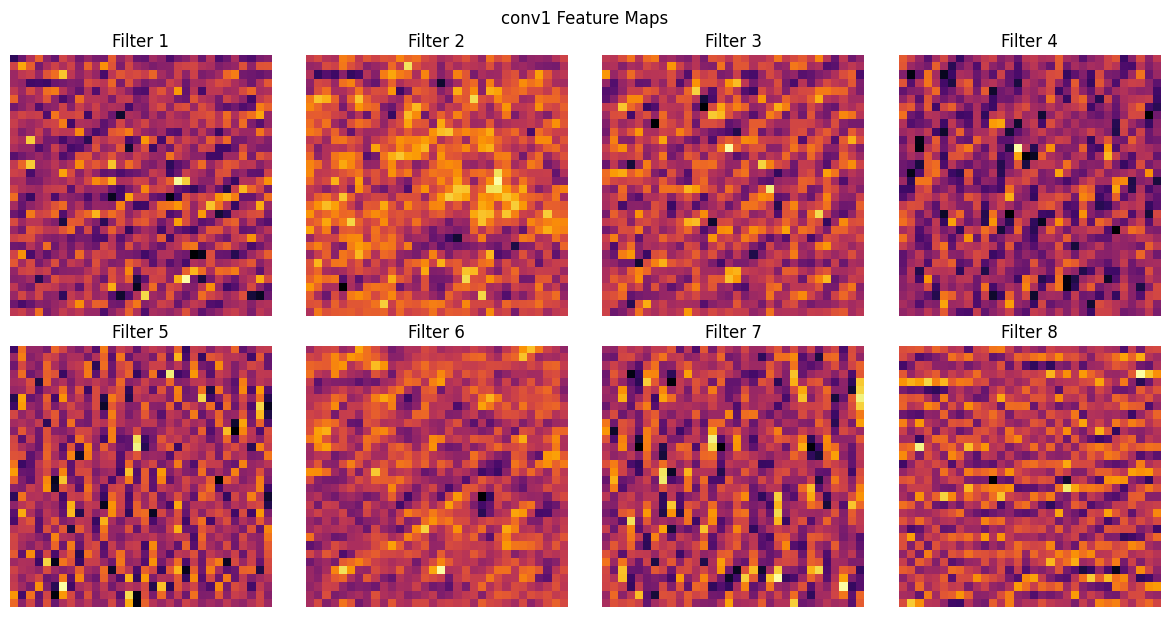

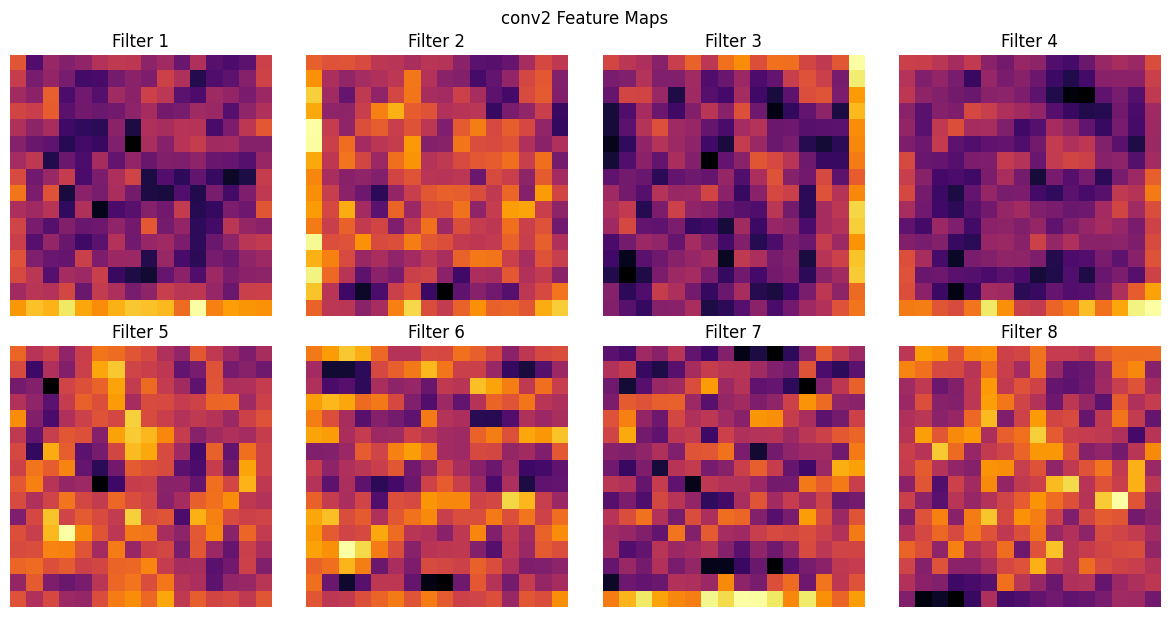

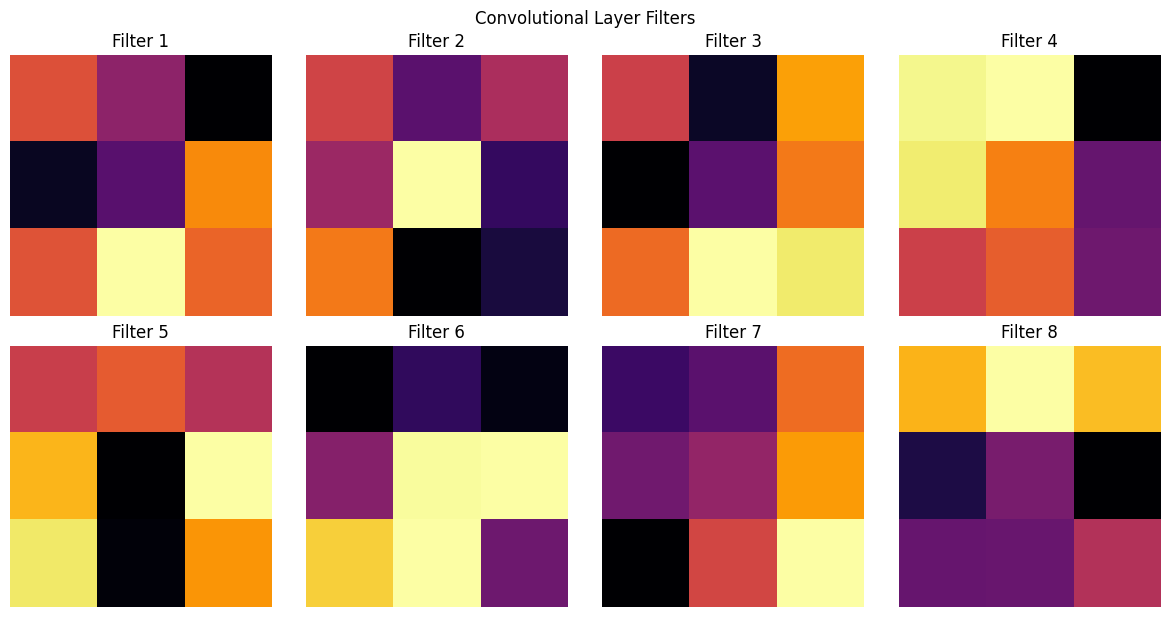

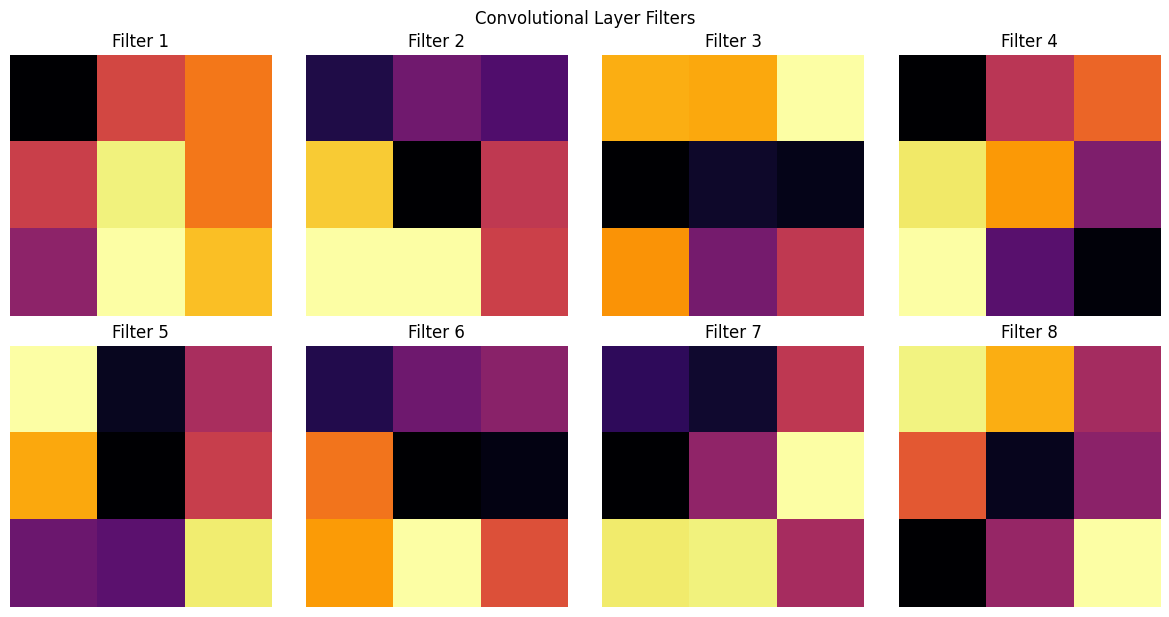

In [29]:
import matplotlib.pyplot as plt

model = networks["CNN"]        # Model
model.to(device)               # Move model to  device
model.eval()                   # Set the model to evaluation mode

# Hook to capture layer activations
activations = {}

def capture_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()
    return hook

# Register hooks for the first two convolutional layers
model.conv1.register_forward_hook(capture_activation('conv1'))
model.conv2.register_forward_hook(capture_activation('conv2')) 

# Use a dummy image or load an actual image resized to match the input dimensions
input_image = torch.randn(1, 3, 32, 32).to(device)  
with torch.no_grad():
    output = model(input_image)  # Forward pass

# Visualize feature maps for a given layer
def visualize_feature_maps(layer_name, num_filters=8):
    feature_maps = activations[layer_name][0]  # Take the first image in the batch
    num_filters = min(num_filters, feature_maps.size(0))  # Limit to available filters

    plt.figure(figsize=(12, 6))
    for i in range(num_filters):
        plt.subplot(2, (num_filters + 1) // 2, i + 1)
        plt.imshow(feature_maps[i], cmap='inferno')
        plt.axis('off')
        plt.title(f'Filter {i + 1}')
    plt.tight_layout()
    plt.suptitle(f'{layer_name} Feature Maps', y=1.02)
    plt.show()

# Visualize filters/kernels for a given layer
def visualize_filters(layer, num_filters=8):
    weights = layer.weight.data.cpu().numpy()  # Extract the weights as a NumPy array
    num_filters = min(num_filters, weights.shape[0])  # Limit to available filters

    plt.figure(figsize=(12, 6))
    for i in range(num_filters):
        plt.subplot(2, (num_filters + 1) // 2, i + 1)
        plt.imshow(weights[i, 0], cmap='inferno')  # Visualize the first channel of the filter
        plt.axis('off')
        plt.title(f'Filter {i + 1}')
    plt.tight_layout()
    plt.suptitle('Convolutional Layer Filters', y=1.02)
    plt.show()

# Plot the activations for the first two layers
visualize_feature_maps('conv1', num_filters=8)
visualize_feature_maps('conv2', num_filters=8)

# Display filters for the first and second convolutional layers
visualize_filters(model.conv1, num_filters=8)
visualize_filters(model.conv2, num_filters=8)

## Compare the results [9 pts]

In this part, you will compare the results of both methods. While answering the questions below, consider the following points:

- What are the advantages and disadvantages of these models?
- In what scenarios would you use a CNN versus a custom ResNet?
- Is early stopping necessary during training? If so, why?
    
Also, feel free to use any library you want.

#### Plot loss and accuracy curves per training epoch for both train and test sets. Make sure you put legend and labels. Comment on the results. [3 pts]

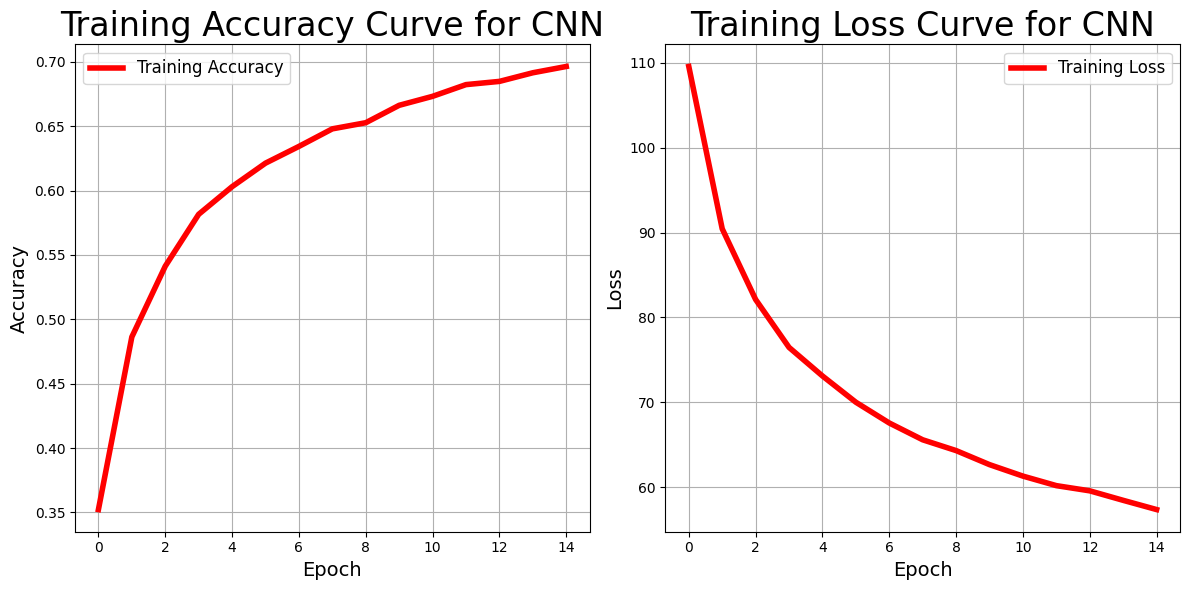

In [30]:
# Extract loss and accuracy values
loss_values = train_data["CNN"]["loss"]
accuracy_values = train_data["CNN"]["accuracy"]

# Create a figure with subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training Accuracy
axes[0].plot(accuracy_values, label='Training Accuracy', color='red', linewidth=4)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].set_title('Training Accuracy Curve for CNN', fontsize=24)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# Plot Training Loss
axes[1].plot(loss_values, label='Training Loss', color='red', linewidth=4)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].set_title('Training Loss Curve for CNN', fontsize=24)
axes[1].legend(fontsize=12)
axes[1].grid(True)


# Adjust layout and display the plots
plt.tight_layout()
plt.show()


#### Visualize a few example test outputs with true and predicted labels (both models). Make comments [3 pts]

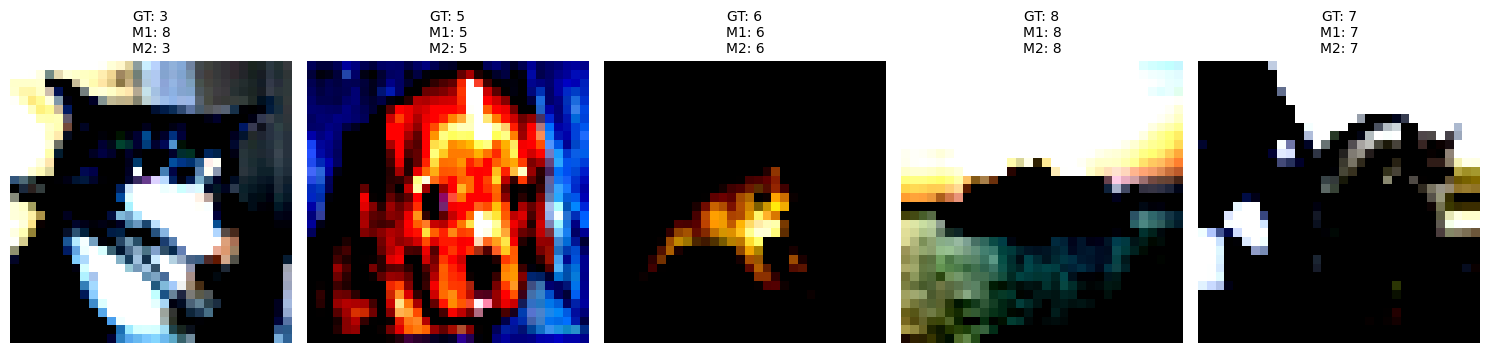

In [31]:
import random

def visualize_test_outputs(model1, model2, test_loader, class_names, device="cpu", num_samples=5):

    # Models to device and set to evaluation mode
    model1.to(device).eval()
    model2.to(device).eval()

    # Collect all test data from the DataLoader
    test_data = [(inputs, targets) for inputs, targets in test_loader]
    inputs, targets = zip(*test_data)

    # Flatten lists of tensors into a single tensor for inputs and targets
    inputs = torch.cat(inputs)
    targets = torch.cat(targets)

    # Select random indices for the specified number of samples
    random_indices = random.sample(range(len(inputs)), num_samples)
    random_inputs = inputs[random_indices].to(device)
    random_targets = targets[random_indices].to(device)

    with torch.no_grad():
        preds1 = model1(random_inputs).argmax(dim=1)  # Predictions from model1
        preds2 = model2(random_inputs).argmax(dim=1)  # Predictions from model2

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Visualize the image with GT and predictions from both models
        plt.subplot(1, num_samples, i + 1)
        img = random_inputs[i].cpu().permute(1, 2, 0).numpy()  # Convert tensor to image
        img = np.clip(img, 0, 1)  # Clip values to valid range [0, 1]
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"GT: {class_names[random_targets[i].item()]}\n"
            f"M1: {class_names[preds1[i].item()]}\n"
            f"M2: {class_names[preds2[i].item()]}",
            fontsize=10,
        )

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]  # Replace with actual class names
visualize_test_outputs(networks["CNN"], networks["customResNet"], test_loader, class_names, device="cuda", num_samples=5)


#### Compare number of parameters of the models. Comment your insights [3 pts]

In [32]:
def count_parameters(model):
    """Count the total number of parameters in a model (trainable and non-trainable)."""
    return sum(param.numel() for param in model.parameters())

cnn_params = count_parameters(networks["CNN"])
resnet_params = count_parameters(networks["customResNet"])

print(f"Total parameters in CNN Model: {cnn_params:,}")
print(f"Total parameters in Custom ResNet Model: {resnet_params:,}")

Total parameters in CNN Model: 320,394
Total parameters in Custom ResNet Model: 4,663,114


# PART IV Object Detection [28 pts]

Object detection is a computer vision task where the goal is to identify and localize objects within an image. 
Unlike image classification, where the focus is on assigning a single label to an image, object detection involves:
- Predicting **what** objects are present (class labels).
- Predicting **where** the objects are located (bounding boxes).

#### Image Classification vs Object Detection:

Image classification answers the question: **What is in the image?**

Object detection answers the questions: **What objects are in the image, and where are they located?**

#### Why Object Detection?
Object detection is used in a variety of real-world applications, such as:
- **Autonomous vehicles**: Detecting pedestrians, vehicles, and traffic signs.
- **Medical imaging**: Identifying abnormalities in scans (e.g., tumors).
- **Surveillance**: Recognizing and tracking people or objects in video feeds.
- **Retail**: Counting products or monitoring shelves.


#### Components of Object Detection:

A basic object detection network typically consists of two outputs:
1. **Class Prediction**: A probability distribution over possible object classes.
2. **Bounding Box Regression**: Coordinates of the bounding box enclosing the object.


- The bounding box is represented as `[x_min, y_min, x_max, y_max]`, where:
  - `(x_min, y_min)` is the top-left corner.
  - `(x_max, y_max)` is the bottom-right corner.
- The network predicts both **what** (class label) and **where** (bounding box coordinates).

### Define a Basic Object Detection Network
The network should:
- Take an image as input.
- Output a class label and four bounding box coordinates.

**Hints**:
- The final layer should output both the class probabilities and bounding box coordinates.
- Use the CNN you trained in the previous part as the backbone of your object detector. Add two heads to your backbone model, where one of the heads will predict the object class and the other will predict the object location. 


**Steps**:
- Implement a network that consists of a backbone and two heads.
- Build forward and backward propagation for the network.
- Use separate loss functions for classification (cross-entropy) and bounding box regression (mean squared error).
- Train the network on the object detection dataset.


### Dataset

You will detect license plates:
https://ieee-dataport.org/open-access/cd-lp-compressed-domain-license-plate-detection-database

The dataset contains 2,400 vehicle images for license plate detection purposes. There are 3 subsets, where you'll use only pixel domain images (2400 images). Since you'll predict the license plate coordinates, number of classes will be 2 (plate and non-plate objects). 

#### Implement the network [10 pts]

In [33]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class PlateDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom dataset for loading images and YOLO annotation files.

        Args:
            root_dir (str): Directory containing images and annotation files.
            transform (callable, optional): Transformation to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith('.jpg')]
        self.annotation_files = [file.replace('.jpg', '.txt') for file in self.image_files]

    def __len__(self):
        """Returns the number of images in the dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Loads an image and its corresponding annotations.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            image (Tensor): Transformed image.
            target (dict): Dictionary containing bounding boxes and labels.
        """
        # Load image
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        # Load annotations
        annot_path = os.path.join(self.root_dir, self.annotation_files[idx])
        boxes, labels = self.parse_yolo_annotation(annot_path, image.size)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

    def parse_yolo_annotation(self, annot_path, img_size):
        """
        Parses YOLO annotations into absolute coordinates.

        Args:
            annot_path (str): Path to the annotation file.
            img_size (tuple): Dimensions of the image (width, height).

        Returns:
            boxes (list): List of bounding boxes in [x_min, y_min, x_max, y_max].
            labels (list): List of class IDs.
        """
        boxes = []
        labels = []

        img_width, img_height = img_size
        with open(annot_path, 'r') as file:
            for line in file:
                class_id, center_x, center_y, width, height = map(float, line.strip().split())

                # Convert YOLO annotations to absolute bounding box coordinates
                x_min = (center_x - width / 2) * img_width
                y_min = (center_y - height / 2) * img_height
                x_max = (center_x + width / 2) * img_width
                y_max = (center_y + height / 2) * img_height

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))

        return boxes, labels


# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to match model input dimensions
    transforms.ToTensor(),
])

# Prepare datasets for training and testing
train_dataset = PlateDataset(root_dir="DB/PixelDomain/Train", transform=train_transform)
test_dataset = PlateDataset(root_dir="DB/PixelDomain/Test", transform=train_transform)

# Custom collate function for DataLoader
def collate_fn(batch):
    """
    Combines a batch of data into tensors for the DataLoader.

    Args:
        batch (list): List of (image, target) tuples.

    Returns:
        images (Tensor): Stacked images.
        labels (Tensor): Concatenated labels.
        bboxes (Tensor): Concatenated bounding boxes.
    """
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    # Stack images and concatenate labels and bounding boxes
    images = torch.stack(images, dim=0)
    labels = torch.cat([t['labels'] for t in targets], dim=0)
    bboxes = torch.cat([t['boxes'] for t in targets], dim=0)

    return images, labels, bboxes

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn
)

# Print dataset sizes
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 1800
Test dataset size: 600


In [34]:
class ObjectDetectionNetwork(nn.Module):
    def __init__(self, backbone):
        super(ObjectDetectionNetwork, self).__init__()
        self.backbone = backbone

        # Classification Head
        self.classification_head = nn.Sequential(
            nn.Linear(backbone.fc3.out_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 2)  # 2 classes
        )

        # Regression Head
        self.regression_head = nn.Sequential(
            nn.Linear(backbone.fc3.out_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 4)  # 4 for bounding box coordinates (x_min, y_min, x_max, y_max)
        )

    def forward(self, x):
        
        features = self.backbone(x)

        class_logits = self.classification_head(features)
        bbox_coords = self.regression_head(features)

        return class_logits, bbox_coords


#### Train the network [5 pts]

In [35]:
# Loss Functions
classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone = networks["CNN"].to(device)  # Use the CNN model as the backbone
model = ObjectDetectionNetwork(backbone).to(device)

train_total_loss = 0.0
train_correct = 0
train_total = 0

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
num_epochs = 20

model.train()
# Training loop
for epoch in range(num_epochs):

    for images, labels, bboxes in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        class_logits, bbox_coords = model(images)

        class_loss = classification_loss(class_logits, labels)
        bbox_loss = regression_loss(bbox_coords, bboxes)

        total_loss = class_loss + bbox_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

            # Calculate train accuracy
        _, predicted = torch.max(class_logits, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}')


avg_train_loss = train_total_loss / len(train_loader)
train_accuracy = train_correct / train_total


# Test loop
model.eval()
running_loss = 0.0
with torch.no_grad():
    for images, labels, bboxes in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        class_logits, bbox_coords = model(images)

        if(labels.size(0) == 65):   # Skip the last batch if it's smaller than the batch size
            continue

        class_loss = classification_loss(class_logits, labels)
        bbox_loss = regression_loss(bbox_coords, bboxes)

        total_loss = class_loss + bbox_loss
        running_loss += total_loss.item()

print(f"Test Loss: {running_loss / len(test_loader)}")


Epoch [1/20], Loss: 4853.8408203125
Epoch [2/20], Loss: 3884.70068359375
Epoch [3/20], Loss: 905.0684204101562
Epoch [4/20], Loss: 116.46862030029297
Epoch [5/20], Loss: 244.72010803222656
Epoch [6/20], Loss: 226.56910705566406
Epoch [7/20], Loss: 225.22061157226562
Epoch [8/20], Loss: 613.674560546875
Epoch [9/20], Loss: 228.89300537109375
Epoch [10/20], Loss: 249.150634765625
Epoch [11/20], Loss: 134.63427734375
Epoch [12/20], Loss: 231.51626586914062
Epoch [13/20], Loss: 206.09701538085938
Epoch [14/20], Loss: 147.35560607910156
Epoch [15/20], Loss: 178.73260498046875
Epoch [16/20], Loss: 212.560302734375
Epoch [17/20], Loss: 74.08887481689453
Epoch [18/20], Loss: 201.32508850097656
Epoch [19/20], Loss: 80.81236267089844
Epoch [20/20], Loss: 100.80984497070312
Test Loss: 41.749102401733396


#### Evaluate the model and plot precision, recall, and mAP scores for different IoU thresholds [5 pts]

Evaluate the network using **evaluate()** below for different IoU thresholds [0.1; 0.1; 1]:



In [36]:

import numpy as np

def calculate_iou(pred_box, gt_box):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Args:
        pred_box (list): [x_min, y_min, x_max, y_max] for the predicted box.
        gt_box (list): [x_min, y_min, x_max, y_max] for the ground truth box.
    Returns:
        float: IoU value.
    """
    # Compute intersection
    x_min_inter = max(pred_box[0], gt_box[0])
    y_min_inter = max(pred_box[1], gt_box[1])
    x_max_inter = min(pred_box[2], gt_box[2])
    y_max_inter = min(pred_box[3], gt_box[3])

    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    
    # Compute union
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def evaluate(predictions, ground_truths, iou_threshold=0.5):
    """
    Evaluate object detection metrics: Precision, Recall, and mAP.
    Args:
        predictions (list): List of predicted bounding boxes [[x_min, y_min, x_max, y_max, class], ...].
        ground_truths (list): List of ground truth boxes [[x_min, y_min, x_max, y_max, class], ...].
        iou_threshold (float): IoU threshold to consider a prediction correct.
    Returns:
        dict: Precision, Recall, and mAP scores.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    matched_gt = set()  # Keep track of matched ground truths

    for pred in predictions:
        pred_box, pred_class = pred[:4], pred[4]
        max_iou = 0
        matched = None

        for i, gt in enumerate(ground_truths):
            gt_box, gt_class = gt[:4], gt[4]

            # Only consider matching predictions of the same class
            if pred_class == gt_class:
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou and iou >= iou_threshold and i not in matched_gt:
                    max_iou = iou
                    matched = i

        if matched is not None:
            tp += 1
            matched_gt.add(matched)
        else:
            fp += 1

    fn = len(ground_truths) - len(matched_gt)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # For simplicity, mAP can be computed as Precision in this example
    # In real scenarios, mAP requires averaging precision at multiple recall thresholds
    mAP = precision

    return {"Precision": precision, "Recall": recall, "mAP": mAP}
"""
# Example data
predictions = [
    [50, 50, 150, 150, "car"],  # [x_min, y_min, x_max, y_max, class]
    [30, 30, 120, 120, "car"],
]

ground_truths = [
    [40, 40, 140, 140, "car"],  # [x_min, y_min, x_max, y_max, class]
    [60, 60, 170, 170, "car"],
]
"""

# Extract predictions and ground truths for evaluation
flat_predictions = []
flat_ground_truths = []

with torch.no_grad():
    for images, labels, bboxes in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        if labels.size(0) == 65:  # Skip small batches
            continue

        class_logits, bbox_coords = model(images)
        predicted_classes = torch.argmax(class_logits, dim=1).cpu().numpy()
        bbox_coords = bbox_coords.cpu().numpy()

        # Flatten predictions and ground truths
        for i in range(len(labels)):
            flat_predictions.append(
                [*bbox_coords[i], predicted_classes[i]]
            )
            flat_ground_truths.append(
                [*bboxes[i].cpu().numpy(), labels[i].cpu().item()]
            )

# Evaluate 
results = evaluate(flat_predictions, flat_ground_truths, iou_threshold=0.1)
results1 = evaluate(flat_predictions, flat_ground_truths, iou_threshold=0.5)
results2 = evaluate(flat_predictions, flat_ground_truths, iou_threshold=0.8)
results3 = evaluate(flat_predictions, flat_ground_truths, iou_threshold=1)

print("Evaluation Results for Intersection Over Union 0.1:", results)
print("Evaluation Results for Intersection Over Union 0.5:", results1)
print("Evaluation Results for Intersection Over Union 0.8:", results2)
print("Evaluation Results for Intersection Over Union 1:", results3)

Evaluation Results for Intersection Over Union 0.1: {'Precision': 0.6059322033898306, 'Recall': 0.6059322033898306, 'mAP': 0.6059322033898306}
Evaluation Results for Intersection Over Union 0.5: {'Precision': 0.3538135593220339, 'Recall': 0.3538135593220339, 'mAP': 0.3538135593220339}
Evaluation Results for Intersection Over Union 0.8: {'Precision': 0.09533898305084745, 'Recall': 0.09533898305084745, 'mAP': 0.09533898305084745}
Evaluation Results for Intersection Over Union 1: {'Precision': 0.0, 'Recall': 0.0, 'mAP': 0.0}


### Comparison [8 pts]
Try different backbones: the Resnet you trained and an untrained (only initialized) CNN.
Do backbones with different architectures affect the object detection performance?

Compare the pretrained and untrained backbones: Do pretrained backbones ease object detection, in your experiments? If not, why?

In [37]:
class ObjectDetectionNetwork(nn.Module):
    def __init__(self, backbone):
        super(ObjectDetectionNetwork, self).__init__()
        self.backbone = backbone

        # Classification Head
        self.classification_head = nn.Sequential(
            nn.Linear(backbone.linear.out_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 2)  # 2 classes
        )

        # Regression Head
        self.regression_head = nn.Sequential(
            nn.Linear(backbone.linear.out_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 4)  # 4 for bounding box coordinates (x_min, y_min, x_max, y_max)
        )

    def forward(self, x):
        
        features = self.backbone(x)

        class_logits = self.classification_head(features)
        bbox_coords = self.regression_head(features)

        return class_logits, bbox_coords


In [38]:
# Loss Functions
classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone = networks["customResNet"].to(device)  # Use the CNN model as the backbone
model = ObjectDetectionNetwork(backbone).to(device)

train_total_loss = 0.0
train_correct = 0
train_total = 0

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
num_epochs = 20

model.train()
# Training loop
for epoch in range(num_epochs):

    for images, labels, bboxes in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        class_logits, bbox_coords = model(images)

        class_loss = classification_loss(class_logits, labels)
        bbox_loss = regression_loss(bbox_coords, bboxes)

        total_loss = class_loss + bbox_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

            # Calculate train accuracy
        _, predicted = torch.max(class_logits, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}')


avg_train_loss = train_total_loss / len(train_loader)
train_accuracy = train_correct / train_total


# Test loop
model.eval()
running_loss = 0.0
with torch.no_grad():
    for images, labels, bboxes in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        class_logits, bbox_coords = model(images)

        if(labels.size(0) == 65):   # Skip the last batch if it's smaller than the batch size
            continue

        class_loss = classification_loss(class_logits, labels)
        bbox_loss = regression_loss(bbox_coords, bboxes)

        total_loss = class_loss + bbox_loss
        running_loss += total_loss.item()

print(f"Test Loss: {running_loss / len(test_loader)}")


Epoch [1/20], Loss: 4732.72021484375
Epoch [2/20], Loss: 3110.547119140625
Epoch [3/20], Loss: 1143.47119140625
Epoch [4/20], Loss: 517.239990234375
Epoch [5/20], Loss: 160.1399383544922
Epoch [6/20], Loss: 108.31385040283203
Epoch [7/20], Loss: 123.80944061279297
Epoch [8/20], Loss: 217.44384765625
Epoch [9/20], Loss: 178.44569396972656
Epoch [10/20], Loss: 118.56698608398438
Epoch [11/20], Loss: 81.24435424804688
Epoch [12/20], Loss: 119.46831512451172
Epoch [13/20], Loss: 81.04442596435547
Epoch [14/20], Loss: 95.6469497680664
Epoch [15/20], Loss: 234.31240844726562
Epoch [16/20], Loss: 101.31607818603516
Epoch [17/20], Loss: 109.77178192138672
Epoch [18/20], Loss: 130.052734375
Epoch [19/20], Loss: 137.23597717285156
Epoch [20/20], Loss: 210.51260375976562
Test Loss: 76.03011703491211


In [39]:

import numpy as np

def calculate_iou(pred_box, gt_box):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Args:
        pred_box (list): [x_min, y_min, x_max, y_max] for the predicted box.
        gt_box (list): [x_min, y_min, x_max, y_max] for the ground truth box.
    Returns:
        float: IoU value.
    """
    # Compute intersection
    x_min_inter = max(pred_box[0], gt_box[0])
    y_min_inter = max(pred_box[1], gt_box[1])
    x_max_inter = min(pred_box[2], gt_box[2])
    y_max_inter = min(pred_box[3], gt_box[3])

    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    
    # Compute union
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def evaluate(predictions, ground_truths, iou_threshold=0.5):
    """
    Evaluate object detection metrics: Precision, Recall, and mAP.
    Args:
        predictions (list): List of predicted bounding boxes [[x_min, y_min, x_max, y_max, class], ...].
        ground_truths (list): List of ground truth boxes [[x_min, y_min, x_max, y_max, class], ...].
        iou_threshold (float): IoU threshold to consider a prediction correct.
    Returns:
        dict: Precision, Recall, and mAP scores.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    matched_gt = set()  # Keep track of matched ground truths

    for pred in predictions:
        pred_box, pred_class = pred[:4], pred[4]
        max_iou = 0
        matched = None

        for i, gt in enumerate(ground_truths):
            gt_box, gt_class = gt[:4], gt[4]

            # Only consider matching predictions of the same class
            if pred_class == gt_class:
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou and iou >= iou_threshold and i not in matched_gt:
                    max_iou = iou
                    matched = i

        if matched is not None:
            tp += 1
            matched_gt.add(matched)
        else:
            fp += 1

    fn = len(ground_truths) - len(matched_gt)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # For simplicity, mAP can be computed as Precision in this example
    # In real scenarios, mAP requires averaging precision at multiple recall thresholds
    mAP = precision

    return {"Precision": precision, "Recall": recall, "mAP": mAP}
"""
# Example data
predictions = [
    [50, 50, 150, 150, "car"],  # [x_min, y_min, x_max, y_max, class]
    [30, 30, 120, 120, "car"],
]

ground_truths = [
    [40, 40, 140, 140, "car"],  # [x_min, y_min, x_max, y_max, class]
    [60, 60, 170, 170, "car"],
]
"""

# Extract predictions and ground truths for evaluation
flat_predictions = []
flat_ground_truths = []

with torch.no_grad():
    for images, labels, bboxes in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        if labels.size(0) == 65:  # Skip small batches
            continue

        class_logits, bbox_coords = model(images)
        predicted_classes = torch.argmax(class_logits, dim=1).cpu().numpy()
        bbox_coords = bbox_coords.cpu().numpy()

        # Flatten predictions and ground truths
        for i in range(len(labels)):
            flat_predictions.append(
                [*bbox_coords[i], predicted_classes[i]]
            )
            flat_ground_truths.append(
                [*bboxes[i].cpu().numpy(), labels[i].cpu().item()]
            )

# Evaluate 
results = evaluate(flat_predictions, flat_ground_truths, iou_threshold=0.1)
results1 = evaluate(flat_predictions, flat_ground_truths, iou_threshold=0.5)
results2 = evaluate(flat_predictions, flat_ground_truths, iou_threshold=0.8)
results3 = evaluate(flat_predictions, flat_ground_truths, iou_threshold=1)

print("Evaluation Results for Intersection Over Union 0.1:", results)
print("Evaluation Results for Intersection Over Union 0.5:", results1)
print("Evaluation Results for Intersection Over Union 0.8:", results2)
print("Evaluation Results for Intersection Over Union 1:", results3)

Evaluation Results for Intersection Over Union 0.1: {'Precision': 0.7478813559322034, 'Recall': 0.7478813559322034, 'mAP': 0.7478813559322034}
Evaluation Results for Intersection Over Union 0.5: {'Precision': 0.5699152542372882, 'Recall': 0.5699152542372882, 'mAP': 0.5699152542372882}
Evaluation Results for Intersection Over Union 0.8: {'Precision': 0.13135593220338984, 'Recall': 0.13135593220338984, 'mAP': 0.13135593220338984}
Evaluation Results for Intersection Over Union 1: {'Precision': 0.0, 'Recall': 0.0, 'mAP': 0.0}
